In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding, Flatten
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    TENSORFLOW_AVAILABLE = True
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not available, using scikit-learn models")

try:
    from preprocessing import GNSSErrorPreprocessor, create_train_test_split
    print("Custom preprocessing module imported")
except ImportError:
    print("Custom preprocessing module not found, will define functions inline")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")

TensorFlow not available, using scikit-learn models
Custom preprocessing module imported
Libraries imported successfully


In [33]:
df = pd.read_csv('errors_day187_192.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['satellite_id', 'timestamp']).reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Satellites: {len(df['satellite_id'].unique())}")

df.head()

Dataset shape: (21504, 6)
Memory usage: 2.05 MB
Date range: 2025-07-06 00:00:00 to 2025-07-12 23:45:00
Satellites: 32


,satellite_id,timestamp,orbit_error_m,clock_error_ns,radial_error_m,ephemeris_age_hours
0,G01,2025-07-06 00:00:00,3.502946e+07,1.256349e+07,-2.311078e+07,0.00
1,G01,2025-07-06 00:15:00,3.537857e+07,1.256349e+07,-2.357213e+07,0.25
2,G01,2025-07-06 00:30:00,3.645217e+07,1.256349e+07,-2.502190e+07,0.50
3,G01,2025-07-06 00:45:00,3.812006e+07,1.256349e+07,-2.736062e+07,0.75
4,G01,2025-07-06 01:00:00,4.020278e+07,1.256349e+07,-3.042803e+07,1.00


In [34]:
print("Dataset Information:")
df.info()

print("\nStatistical Summary:")
df.describe()

print("\nMissing Values:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\nSatellite Distribution:")
satellite_counts = df['satellite_id'].value_counts().sort_index()
print(satellite_counts)

print("\nTemporal Distribution:")
df['day'] = df['timestamp'].dt.day
day_counts = df['day'].value_counts().sort_index()
print("Records per day:")
for day, count in day_counts.items():
    print(f"  Day {day}: {count:,} records")

print("\nTarget Variable Ranges:")
print(f"Orbit Error (m): {df['orbit_error_m'].min():.3f} to {df['orbit_error_m'].max():.3f}")
print(f"Clock Error (ns): {df['clock_error_ns'].min():.3f} to {df['clock_error_ns'].max():.3f}")
print(f"Radial Error (m): {df['radial_error_m'].min():.3f} to {df['radial_error_m'].max():.3f}")
print(f"Ephemeris Age (hrs): {df['ephemeris_age_hours'].min():.3f} to {df['ephemeris_age_hours'].max():.3f}")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21504 entries, 0 to 21503
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   satellite_id         21504 non-null  object        
 1   timestamp            21504 non-null  datetime64[ns]
 2   orbit_error_m        21504 non-null  float64       
 3   clock_error_ns       21408 non-null  float64       
 4   radial_error_m       21432 non-null  float64       
 5   ephemeris_age_hours  21504 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1008.1+ KB

Statistical Summary:

Missing Values:
                Missing Count  Missing Percentage
clock_error_ns             96            0.446429
radial_error_m             72            0.334821

Satellite Distribution:
satellite_id
G01    672
G02    672
G03    672
G04    672
G05    672
G06    672
G07    672
G08    672
G09    672
G10    672
G11 

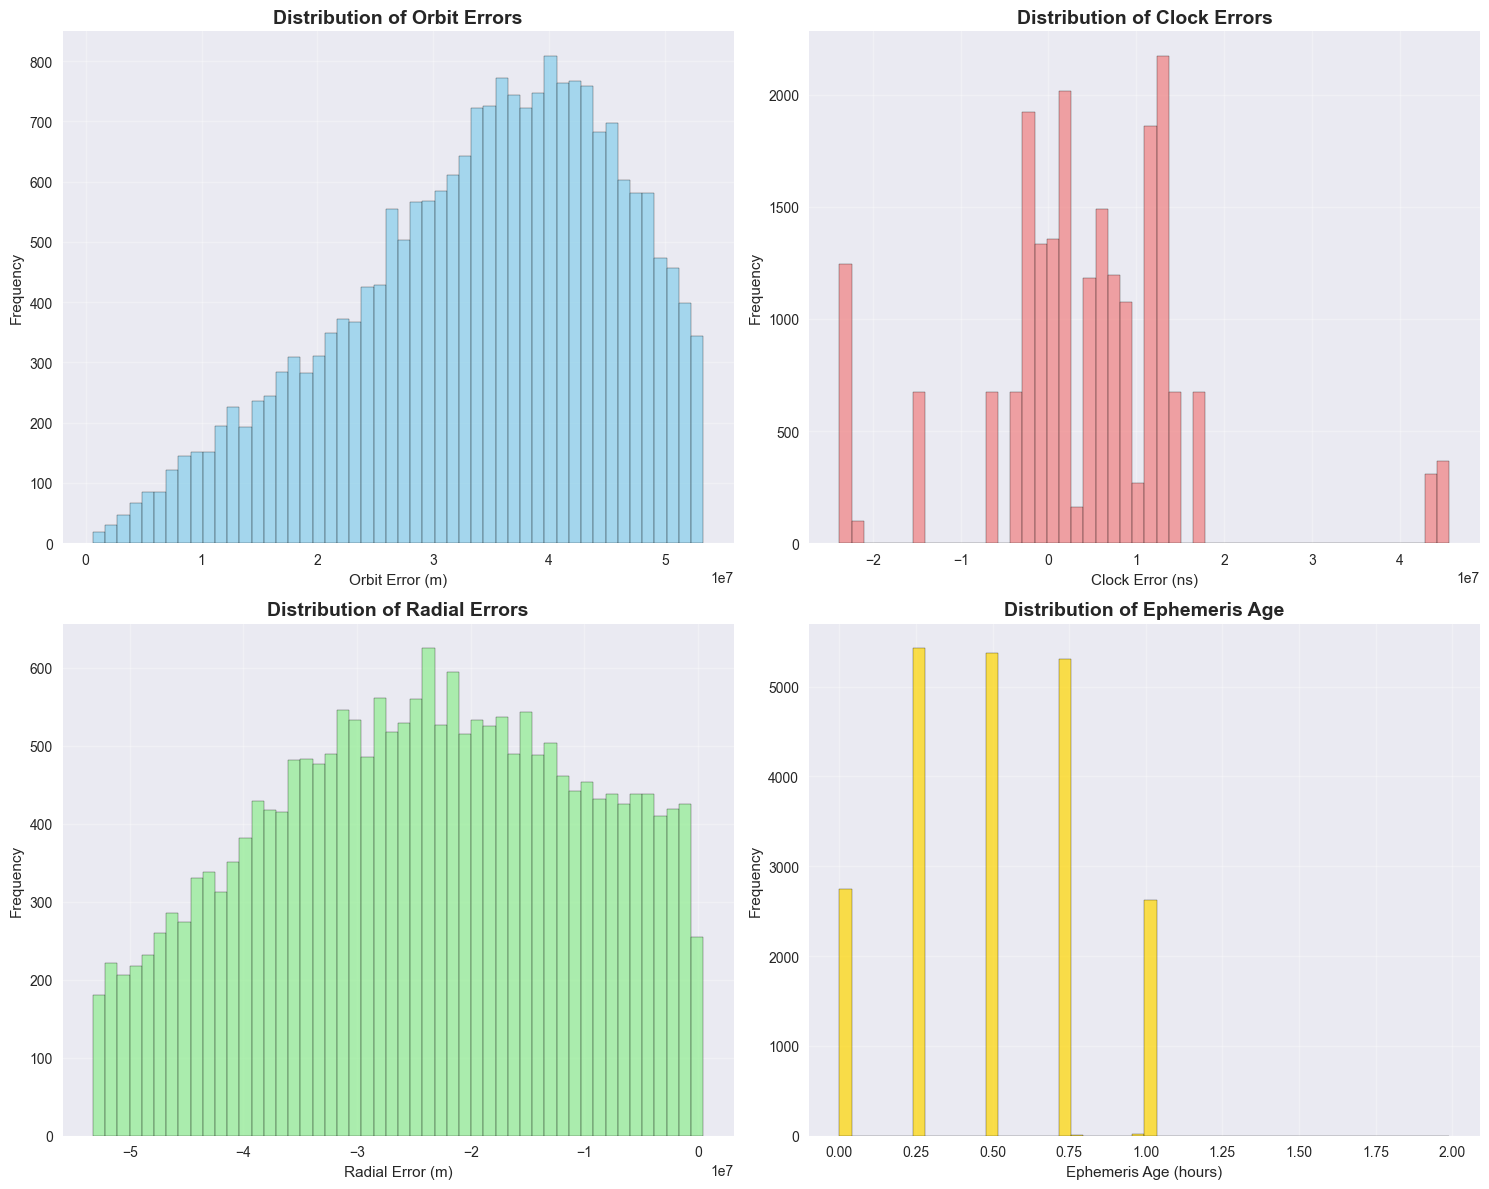


Correlation Matrix:


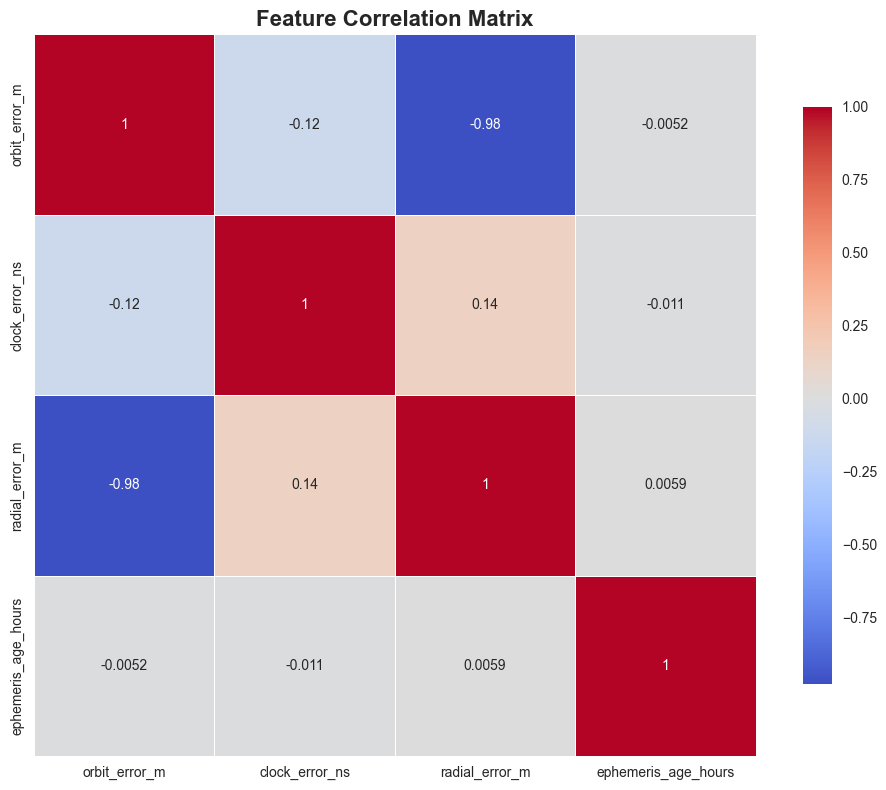

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].hist(df['orbit_error_m'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Orbit Errors', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Orbit Error (m)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(df['clock_error_ns'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Clock Errors', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Clock Error (ns)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(df['radial_error_m'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribution of Radial Errors', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Radial Error (m)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(df['ephemeris_age_hours'], bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_title('Distribution of Ephemeris Age', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Ephemeris Age (hours)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
correlation_matrix = df[['orbit_error_m', 'clock_error_ns', 'radial_error_m', 'ephemeris_age_hours']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [36]:
print("Data Cleaning:")
print(f"Initial dataset shape: {df.shape}")
initial_records = len(df)

print(f"\nMissing values check:")
nan_counts = df.isnull().sum()
for col, count in nan_counts.items():
    if count > 0:
        print(f"  {col}: {count} NaN values ({count/len(df)*100:.2f}%)")

print(f"\nInfinite values check:")
for col in df.select_dtypes(include=[np.number]).columns:
    inf_count = np.isinf(df[col]).sum()
    if inf_count > 0:
        print(f"  {col}: {inf_count} infinite values")

critical_columns = ['orbit_error_m', 'clock_error_ns', 'satellite_id', 'timestamp']
df_clean = df.dropna(subset=critical_columns)

print(f"\nAfter removing NaN values:")
print(f"  Records removed: {initial_records - len(df_clean)}")
print(f"  Remaining records: {len(df_clean)}")
print(f"  Data retention: {len(df_clean)/initial_records*100:.2f}%")

# Detect outliers using IQR method
def detect_outliers(series, k=1.5):
    """Detect outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
def detect_outliers(series, k=1.5):
    """Detect outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return (series < lower_bound) | (series > upper_bound)

print(f"\nOutlier Detection:")
outlier_columns = ['orbit_error_m', 'clock_error_ns', 'radial_error_m']
outlier_masks = {}
    outlier_percentage = outlier_count / len(df_clean) * 100
for col in outlier_columns:
    outliers = detect_outliers(df_clean[col])
    outlier_count = outliers.sum()
    outlier_percentage = outlier_count / len(df_clean) * 100
    outlier_masks[col] = outliers
    
    print(f"{col}:")
    print(f"  Outliers: {outlier_count} ({outlier_percentage:.2f}%)")

    if outlier_count > 0:
        print(f"  Range: {df_clean[col].min():.3f} to {df_clean[col].max():.3f}")
        print(f"  Outlier range: {df_clean.loc[outliers, col].min():.3f} to {df_clean.loc[outliers, col].max():.3f}")

combined_outliers = np.logical_or.reduce(list(outlier_masks.values()))
print(f"\nTotal rows with outliers: {combined_outliers.sum()} ({combined_outliers.sum()/len(df_clean)*100:.2f}%)")
df_clean['has_outlier'] = combined_outliers
df_clean['has_outlier'] = combined_outliers

print(f"\nData Quality Check:")
print(f"Final dataset shape: {df_clean.shape}")
print(f"No missing values in critical columns: {df_clean[critical_columns].isnull().sum().sum() == 0}")
print(f"Temporal continuity maintained: {df_clean['timestamp'].is_monotonic_increasing}")
print(f"All satellites present: {len(df_clean['satellite_id'].unique())} satellites")
print(f"All satellites present: {len(df_clean['satellite_id'].unique())} satellites")
df = df_clean.copy()
print(f"\nReady for preprocessing with {len(df):,} clean records")

IndentationError: unexpected indent (511179897.py, line 44)

In [ ]:
print("Feature Engineering:")

df['hour'] = df['timestamp'].dt.hour
df['day_of_year'] = df['timestamp'].dt.dayofyear
df['minute_of_day'] = df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute
df['satellite_constellation'] = df['satellite_id'].apply(lambda x: int(x[1:]) // 8)

window_size = 16
print("Calculating rolling statistics...")
rolling_features = []

for satellite in df['satellite_id'].unique():
    sat_data = df[df['satellite_id'] == satellite].copy()
    sat_data = sat_data.sort_values('timestamp')
    
    sat_data['orbit_error_ma_4h'] = sat_data['orbit_error_m'].rolling(window=window_size, min_periods=1).mean()
    sat_data['clock_error_ma_4h'] = sat_data['clock_error_ns'].rolling(window=window_size, min_periods=1).mean()
    sat_data['orbit_error_std_4h'] = sat_data['orbit_error_m'].rolling(window=window_size, min_periods=1).std()
    sat_data['clock_error_std_4h'] = sat_data['clock_error_ns'].rolling(window=window_size, min_periods=1).std()
    sat_data['orbit_error_diff'] = sat_data['orbit_error_m'].diff()
    sat_data['clock_error_diff'] = sat_data['clock_error_ns'].diff()
    
    rolling_features.append(sat_data)

df_featured = pd.concat(rolling_features, ignore_index=True)
df_featured = df_featured.sort_values(['satellite_id', 'timestamp']).reset_index(drop=True)

df_featured['orbit_error_diff'] = df_featured['orbit_error_diff'].fillna(0)
df_featured['clock_error_diff'] = df_featured['clock_error_diff'].fillna(0)
df_featured['orbit_error_std_4h'] = df_featured['orbit_error_std_4h'].fillna(0)
df_featured['clock_error_std_4h'] = df_featured['clock_error_std_4h'].fillna(0)

print(f"Feature engineering completed")
print(f"Original features: {df.shape[1]}")
print(f"Enhanced features: {df_featured.shape[1]}")
print(f"New features added: {df_featured.shape[1] - df.shape[1]}")

new_features = [col for col in df_featured.columns if col not in df.columns]
print(f"\nNew features: {new_features}")

df = df_featured.copy()

# Show feature summary
print(f"\n📊 Feature Summary:")
print("="*50)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Total features: {len(df.columns)}")

In [ ]:
print("Train/Validation Split:")

df['day'] = df['timestamp'].dt.day
max_day = df['day'].max()
train_df = df[df['day'] < max_day].copy()
val_df = df[df['day'] == max_day].copy()

print(f"Training set:")
print(f"  Period: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"  Records: {len(train_df):,}")
print(f"  Days: {sorted(train_df['day'].unique())}")
print(f"  Satellites: {len(train_df['satellite_id'].unique())}")

print(f"\nValidation set:")
print(f"  Period: {val_df['timestamp'].min()} to {val_df['timestamp'].max()}")
print(f"  Records: {len(val_df):,}")
print(f"  Days: {sorted(val_df['day'].unique())}")
print(f"  Satellites: {len(val_df['satellite_id'].unique())}")

print(f"\nData Integrity Check:")
print(f"  No temporal overlap: {train_df['timestamp'].max() < val_df['timestamp'].min()}")
print(f"  All satellites in both sets: {set(train_df['satellite_id'].unique()) == set(val_df['satellite_id'].unique())}")
print(f"  Total records: {len(train_df) + len(val_df)} (original: {len(df)})")

print(f"\nDay-based split complete: {len(train_df):,} training and {len(val_df):,} validation records")

In [ ]:
print("Preprocessing Configuration:")

preprocessing_configs = [
    {
        'name': 'Standard Config',
        'normalization_method': 'standard',
        'encoding_method': 'embedding',
        'lookback_window': 12,
        'prediction_horizon': 1
    },
    {
        'name': 'MinMax Config',
        'normalization_method': 'minmax',
        'encoding_method': 'embedding',
        'lookback_window': 8,
        'prediction_horizon': 1
    },
    {
        'name': 'OneHot Config',
        'normalization_method': 'standard',
        'encoding_method': 'onehot',
        'lookback_window': 6,
        'prediction_horizon': 1
    }
]

processed_datasets = {}

for config in preprocessing_configs:
    print(f"\nTesting {config['name']}:")
    print(f"  Normalization: {config['normalization_method']}")
    print(f"  Encoding: {config['encoding_method']}")
    print(f"  Lookback window: {config['lookback_window']} steps ({config['lookback_window'] * 0.25:.1f} hours)")
    print(f"  Prediction horizon: {config['prediction_horizon']} step(s)")
    
    preprocessor = GNSSErrorPreprocessor(
        normalization_method=config['normalization_method'],
        encoding_method=config['encoding_method'],
        lookback_window=config['lookback_window'],
        prediction_horizon=config['prediction_horizon']
    )
    
    core_columns = ['satellite_id', 'timestamp', 'orbit_error_m', 'clock_error_ns', 'ephemeris_age_hours']
    train_core = train_df[core_columns].copy()
    val_core = val_df[core_columns].copy()
    
    X_train, y_train = preprocessor.fit_transform(train_core)
    X_val, y_val = preprocessor.transform(val_core)
    
    processed_datasets[config['name']] = {
        'preprocessor': preprocessor,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'config': config
    }
    
    print(f"  Training sequences: {X_train.shape}")
    print(f"  Validation sequences: {X_val.shape}")

selected_config = 'Standard Config'
selected_data = processed_datasets[selected_config]

print(f"\nSelected Configuration: {selected_config}")

X_train = selected_data['X_train']
y_train = selected_data['y_train']
X_val = selected_data['X_val']
y_val = selected_data['y_val']
preprocessor = selected_data['preprocessor']

print(f"Training data shape:")
print(f"  X_train: {X_train.shape} (samples, time_steps, features)")
print(f"  y_train: {y_train.shape} (samples, prediction_steps, targets)")

print(f"\nValidation data shape:")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")

info = preprocessor.get_preprocessing_info()
print(f"\nPreprocessor Details:")
for key, value in info.items():
    if key not in ['satellite_mapping', 'feature_names']:
        print(f"  {key}: {value}")

In [ ]:
print("Checking for NaN values in training data...")
print(f"X_train_ml has NaN: {np.isnan(X_train_ml).any()}")
print(f"y_train_ml has NaN: {np.isnan(y_train_ml).any()}")
print(f"X_val_ml has NaN: {np.isnan(X_val_ml).any()}")
print(f"y_val_ml has NaN: {np.isnan(y_val_ml).any()}")

nan_counts_X_train = np.isnan(X_train_ml).sum()
nan_counts_y_train = np.isnan(y_train_ml).sum()
print(f"\nNaN counts in X_train: {nan_counts_X_train}")
print(f"NaN counts in y_train: {nan_counts_y_train}")

print("\nCleaning data by removing NaN values...")
valid_indices = ~(np.isnan(X_train_ml).any(axis=1) | np.isnan(y_train_ml).any(axis=1))
X_train_clean = X_train_ml[valid_indices]
y_train_clean = y_train_ml[valid_indices]

valid_indices_val = ~(np.isnan(X_val_ml).any(axis=1) | np.isnan(y_val_ml).any(axis=1))
X_val_clean = X_val_ml[valid_indices_val]
y_val_clean = y_val_ml[valid_indices_val]

print(f"Original training samples: {X_train_ml.shape[0]}")
print(f"Clean training samples: {X_train_clean.shape[0]}")
print(f"Original validation samples: {X_val_ml.shape[0]}")
print(f"Clean validation samples: {X_val_clean.shape[0]}")

X_train_ml = X_train_clean
y_train_ml = y_train_clean
X_val_ml = X_val_clean
y_val_ml = y_val_clean

print(f"\nFinal clean data shapes:")
print(f"X_train: {X_train_ml.shape}, y_train: {y_train_ml.shape}")
print(f"X_val: {X_val_ml.shape}, y_val: {y_val_ml.shape}")

In [ ]:
# Preprocessing Summary
print("Preprocessing Complete")
print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Features per timestep: {X_train.shape[2]}")
print(f"Sequence length: {X_train.shape[1]} timesteps")
print(f"Target variables: {y_train.shape[1] if len(y_train.shape) > 1 else 1}")
